In [12]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, ZeroPadding2D, Convolution2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as K
from skimage.transform import resize
from skimage.io import imsave
import os
import csv 

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
working_path = "/disk1/luna16/output/"
main_path = "/disk1/luna16/"
unet_weight = "/root/sharedfolder/luna16/unet.hdf5"
BATCH_SIZE= 6
EPOCHS=1
img_rows = 512
img_cols = 512

smooth = 1.

In [2]:
import matplotlib.pyplot as plt
import pylab
img = np.load(main_path+"trainImages.npy").astype(np.float32)
mask = np.load(main_path+"trainMasks.npy").astype(np.float32)

In [3]:
def get_model():
    
    inputs = Input((1, img_rows, img_cols))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics = ['accuracy'])

    return model

In [4]:
print('-'*30)
print('Loading and preprocessing train data...')

imgs_train = np.load(main_path+"trainImages.npy").astype(np.float32)
imgs_mask_train = np.load(main_path+"trainMasks.npy").astype(np.float32)

#     imgs_test = np.load(working_path+"valImages.npy").astype(np.float32)
#     imgs_mask_test_true = np.load(working_path+"valMasks.npy").astype(np.float32)

imgs_test = np.load(main_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(main_path+"testMasks.npy").astype(np.float32)

mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std

print('-'*30)
print('Creating and compiling model...')

model = get_model()

# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint('best_unet.hdf5', monitor='loss', save_best_only=True)
tb = TensorBoard(log_dir="logs_unet", batch_size=BATCH_SIZE)
# Set argument for call to train_and_predict to true at end of script

------------------------------
Loading and preprocessing train data...
------------------------------
Creating and compiling model...


In [5]:
num_test = len(mask)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)

for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_train[i:i+1]], verbose=0)[0]
    
np.save('masksTestPredicted.npy', imgs_mask_test)

In [6]:
import matplotlib.pyplot as plt
import pylab
masks_predict = np.load("/root/sharedfolder/luna16/masksTestPredicted.npy").astype(np.float32)

(512, 512)

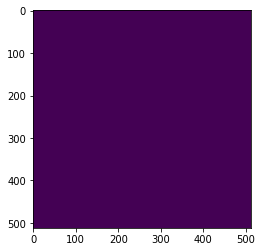

In [7]:
test = masks_predict[51].reshape(512,512)

plt.imshow(test)
test.shape

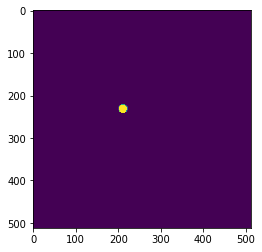

In [9]:
imgs_mask_test_true = np.load(main_path+"testMasks.npy").astype(np.float32)
a = imgs_mask_test_true[39].reshape(512, 512)
plt.imshow(a)

True

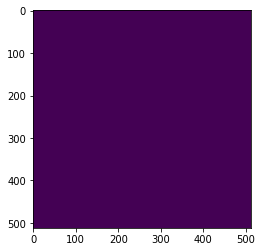

In [26]:
b = imgs_mask_test_reshape[53]
plt.imshow(b)
all_zeros = not np.any(b)
all_zeros

In [8]:
imgs_mask_test_true.shape

(316, 1, 512, 512)

# create bounding box csv file

In [ ]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [13]:
len_img = len(imgs_mask_test_true)
print (len_img)
imgs_mask_test_reshape = imgs_mask_test_true.reshape(len_img, 512, 512)

with open('output_boundingbox.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(['item', 'xmin', 'xmax', 'ymin', 'ymax'])
    line = 0
    for i in range(len_img):
        item = i
        #check if arrays contains all zero
        all_zeros = not np.any(imgs_mask_test_reshape[i])
        if all_zeros == False:
            b = bbox(imgs_mask_test_reshape[i])
            xmin = b[0]
            xmax = b[1]
            ymin = b[2]
            ymax = b[3]
        else:
            xmin = 0
            xmax = 0
            ymin = 0
            ymax = 0
        csv_writer.writerow([item, xmin, xmax, ymin, ymax])
        line += 1

316
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
